In [151]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import numpy as np
import seaborn as sns
%matplotlib inline

In [152]:
nomis_df_one = pd.read_csv("./nomis_data/Nomis Solutions_Data Part I.csv").dropna()
nomis_df_two = pd.read_csv("./nomis_data/Nomis Solutions Part II.csv")

nomis_df_one.dropna(inplace=True)

In [153]:
nomis_df_one['Approve Date'][1].replace("/", "-")

'7-1-02'

In [154]:
nomis_df_one.tail()

# plt.plot(nomis_df_one['Approve Date'], nomis_df_one['Rate'])

,Tier,FICO,Approve Date,Term,Amount,Previous Rate,Car Type,Competition rate,Outcome,Rate,Cost of Funds,Partner Bin
208072,1.0,777.0,11/16/04,48.0,35000.0,,N,4.45,0.0,4.45,2.127,3.0
208073,1.0,790.0,11/16/04,60.0,25000.0,,N,4.45,0.0,4.45,2.127,3.0
208074,4.0,663.0,11/16/04,60.0,31800.0,,N,4.45,0.0,10.85,2.127,3.0
208075,1.0,742.0,11/16/04,60.0,33000.0,,N,4.45,0.0,4.45,2.127,1.0
208078,3.0,685.0,11/16/04,60.0,20022.0,8,R,5.55,0.0,6.53,2.127,3.0


In [155]:
date_and_rate = nomis_df_one[['Approve Date', 'Rate']]
date_and_rate = date_and_rate.sort_values('Approve Date').dropna()
pd.to_datetime(date_and_rate['Approve Date'])

27823    2003-01-01
27794    2003-01-01
27796    2003-01-01
27797    2003-01-01
27798    2003-01-01
27807    2003-01-01
27808    2003-01-01
27810    2003-01-01
27788    2003-01-01
27811    2003-01-01
27813    2003-01-01
27816    2003-01-01
27817    2003-01-01
27818    2003-01-01
27819    2003-01-01
27822    2003-01-01
27828    2003-01-01
27812    2003-01-01
27787    2003-01-01
27783    2003-01-01
27782    2003-01-01
27755    2003-01-01
27757    2003-01-01
27758    2003-01-01
27759    2003-01-01
27760    2003-01-01
27761    2003-01-01
27762    2003-01-01
27763    2003-01-01
27764    2003-01-01
            ...    
191812   2004-09-09
191813   2004-09-09
191814   2004-09-09
191815   2004-09-09
191816   2004-09-09
191817   2004-09-09
191818   2004-09-09
191819   2004-09-09
191820   2004-09-09
191821   2004-09-09
191822   2004-09-09
191823   2004-09-09
191824   2004-09-09
191825   2004-09-09
191826   2004-09-09
191827   2004-09-09
191828   2004-09-09
191829   2004-09-09
191830   2004-09-09


In [156]:
# date_and_rate['month_year'] = date_and_rate['Approve Date'].apply(lambda x: x[0]+"_"+x[4:6])
# df = date_and_rate.groupby('month_year')
# date_and_rate

In [157]:
# date_and_rate.tail()

In [158]:
# nomis_df_one.tail()

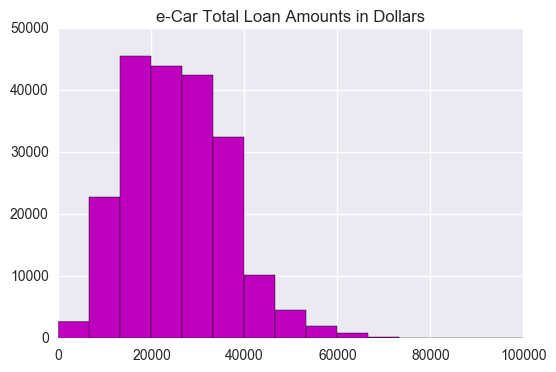

In [159]:
(nomis_df_one['Amount']).hist(bins=15, color='m')
plt.title("e-Car Total Loan Amounts in Dollars")

In [160]:
new_columns = []

for column in nomis_df_one.columns:
    new_columns.append("_".join(column.lower().split()))
    
nomis_df_one.columns = new_columns
nomis_df_one.drop('approve_date', axis=1, inplace=True)

In [161]:
# define function to calculate net present value
# based on amount of loan, APR, term length, and cost of capital

def calculate_NPV(loan_amt, APR, term_in_months, cost_of_capital):
    r = APR/12/100
    r_c = cost_of_capital/12/100
    
    numerator = (1+r)**term_in_months
    monthly_payment = loan_amt*r*(numerator/(numerator-1))
    
    PV = monthly_payment*(1-(1+r_c)**(-term_in_months))/r_c
    
    NPV = PV - loan_amt
    
    return NPV

In [162]:
# make a dictionary mapping tuple of tier segment, loan amount segment, car type segment, partner bin segment,
# and term length segment to overall segment

tier_list = [1,2,3,4]
amount_list = [1,2,3,4]
car_type_list = [1,2,3]
partner_bin_list = [1,2,3]
term_length_list = [1,2,3,4,5]

segment_map = {}

segment = 1

for tier in tier_list:
    for amount in amount_list:
        for car_type in car_type_list:
            for partner_bin in partner_bin_list:
                for term_length in term_length_list:
                    segment_map[(tier, amount, car_type, partner_bin, term_length)] = segment
                    segment += 1


def convert_to_segments(data_row, segment_map):
    if data_row['tier'] == 1.0:
        tier_seg = 1
        
    elif data_row['tier'] == 2.0:
        tier_seg = 2
        
    elif data_row['tier'] == 3.0:
        tier_seg = 3
        
    else:
        tier_seg = 4
    
    if data_row['amount'] > 33000:
        amount_seg = 1
        
    elif data_row['amount'] > 25000:
        amount_seg = 2
        
    elif data_row['amount'] > 17800:
        amount_seg = 3
        
    else:
        amount_seg = 4
        
    if data_row['car_type'] == "N":
        car_type_seg = 1
        
    elif data_row['car_type'] == "U":
        car_type_seg = 2
        
    else:
        car_type_seg = 3
        
    if data_row['partner_bin'] == 1.0:
        partner_bin_seg = 1
        
    elif data_row['partner_bin'] == 2.0:
        partner_bin_seg = 2
        
    else:
        partner_bin_seg = 3
        
    if data_row['term'] == 36.0:
        term_seg = 1
        
    elif data_row['term'] == 48.0:
        term_seg = 2
        
    elif data_row['term'] == 60.0:
        term_seg = 3
        
    elif data_row['term'] == 66.0:
        term_seg = 4
        
    else:
        term_seg = 5
        
    return segment_map[(tier_seg, amount_seg, car_type_seg, partner_bin_seg, term_seg)]

In [163]:
# add segment column to dataframe

segments = nomis_df_one.apply(lambda x: convert_to_segments(x, segment_map), axis=1)
nomis_df_one['segment'] = segments

In [164]:
# set cost of capital constant

COST_OF_CAPITAL = nomis_df_one['cost_of_funds'].mean()

/Users/justw/anaconda/envs/nlp/lib/python3.5/site-packages/ipykernel/__main__.py:28: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/justw/anaconda/envs/nlp/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


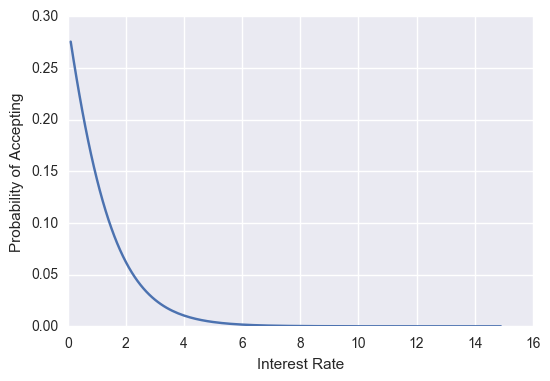

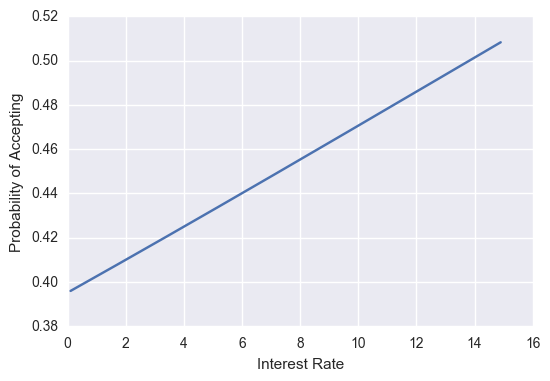

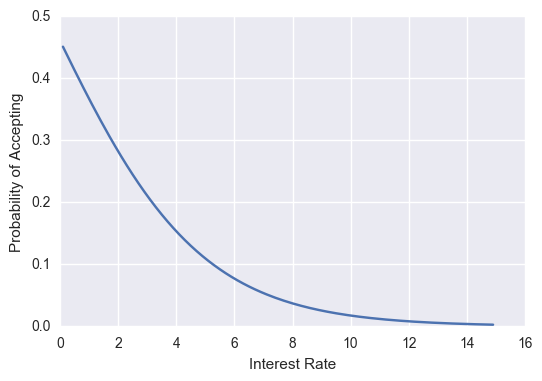

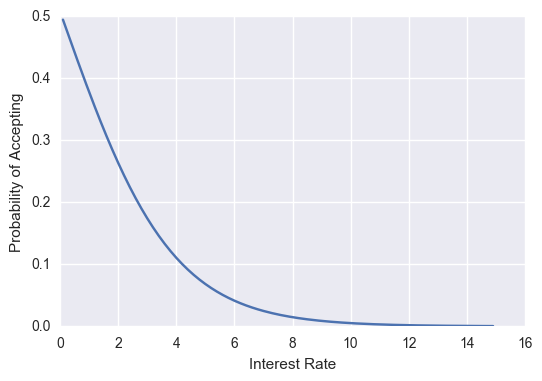

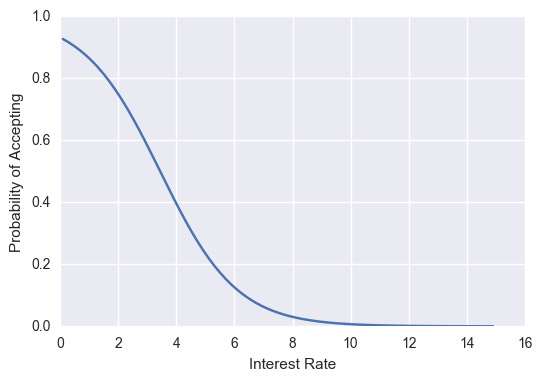

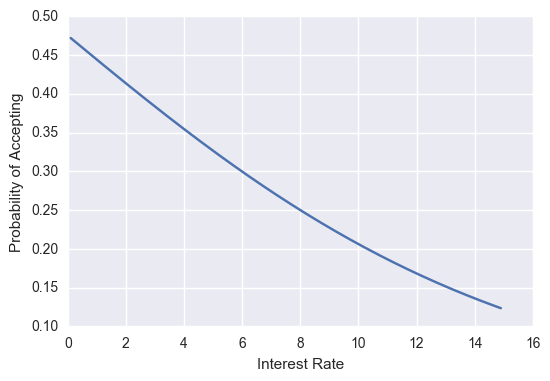

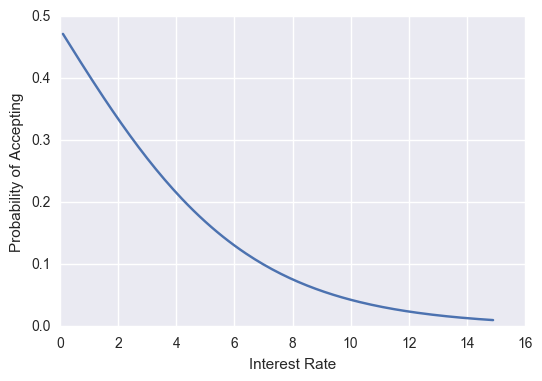

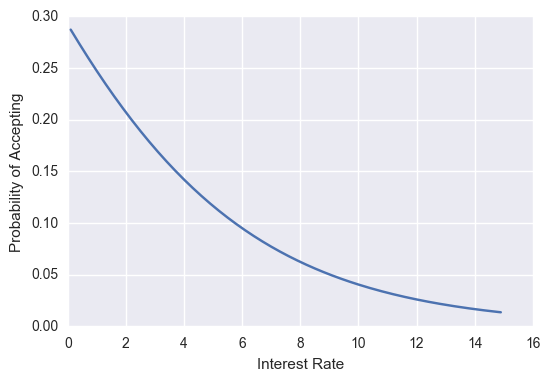

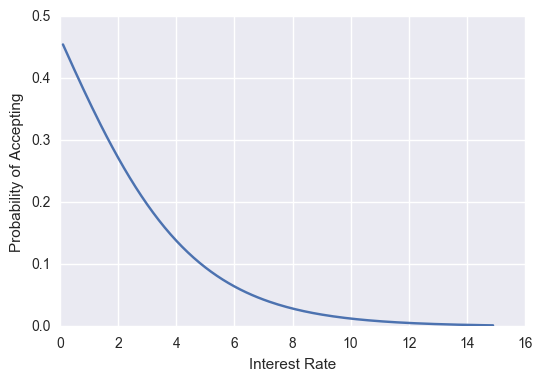

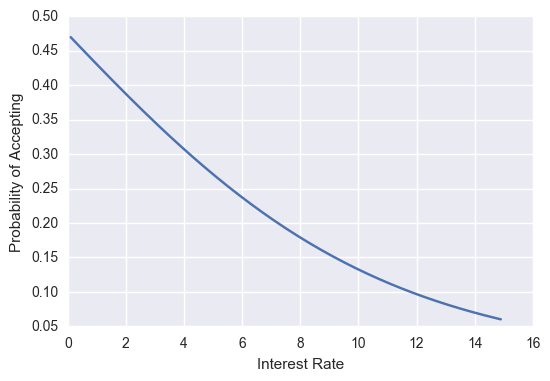

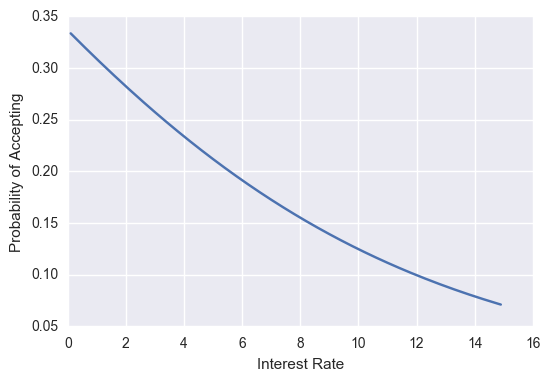

KeyboardInterrupt: 

In [204]:
# build two dictionarys
# keys are segments
# values are trained logistic models and the best APR rate

logistic_models = {}
best_APR = {}

possible_APRs = list(np.arange(.1, 15, .1))

for segment in segment_map.values():
    logisticModel = LogisticRegression()
    
    this_segment = nomis_df_one[nomis_df_one['segment'] == segment]
    
    if len(this_segment) == 0:
        continue
    
    avg_segment_loan_amt = float(this_segment['amount'].mean())
    
    segment_loan_term = float(this_segment['term'].max())
    
    X = this_segment['rate']
    y = this_segment['outcome']
    
    if y.mean() == 0.0 or y.mean() == 1.0:
        continue
    
    logisticModel.fit(X.reshape(len(X),1), y.reshape(len(y), 1))
    
    logistic_models[segment] = logisticModel
    
    profits_per_APR = []
    
    flag = False
    
    probabilities = []
    
    for APR in possible_APRs:
        
        probability_of_accepting = logisticModel.predict_proba(APR)[0][1]
        
        probabilities.append(probability_of_accepting)
        
        APR_NPV = calculate_NPV(avg_segment_loan_amt, APR, segment_loan_term, COST_OF_CAPITAL)
        
        adjusted_NPV = probability_of_accepting*APR_NPV
        
        profits_per_APR.append(adjusted_NPV)
        
        if APR == 2:
            flag = True
        if APR == 3:
            flag = False
    
    if flag:
#         profits_per_APR = [*map(lambda x: x/100, profits_per_APR)]
#         print(profits_per_APR)
        plt.plot(possible_APRs, probabilities)
        plt.ylabel('Probability of Accepting')
        plt.xlabel('Interest Rate')
        
        plt.show()
    
        
    best_segment_APR = possible_APRs[np.argmax(profits_per_APR)]
        
    best_APR[segment] = best_segment_APR

In [166]:
def get_our_APR(data_row):
    try:
        return best_APR[data_row['segment']]
    
    except KeyError:
        return data_row['rate']
    
def get_their_NPV(data_row):
    if data_row['outcome'] == 0.0:
        return 0
    
    return calculate_NPV(data_row['amount'], data_row['rate'], data_row['term'], data_row['cost_of_funds'])

def get_our_NPV(data_row, logistic_models):
    try:
        prob = logistic_models[data_row['segment']].predict_proba(data_row['our_APR'])[0][1]
    except:
        prob = data_row['outcome']

    return calculate_NPV(data_row['amount'], data_row['our_APR'], data_row['term'], data_row['cost_of_funds'])*prob

In [167]:
nomis_df_one['our_APR'] = nomis_df_one.apply(get_our_APR, axis=1)
nomis_df_one.head()
nomis_df_one['their_NPV'] = nomis_df_one.apply(get_their_NPV, axis=1)

In [168]:
nomis_df_one['our_NPV'] = nomis_df_one.apply(lambda x: get_our_NPV(x, logistic_models), axis=1)

In [170]:
our_total_value = nomis_df_one['our_NPV'].sum()
their_total_value = nomis_df_one['their_NPV'].sum()

print(our_total_value)
print(their_total_value)

200939584.683
94940078.2757


In [178]:
segment = nomis_df_one[nomis_df_one['segment'] == 2]
segment.tail()

,tier,fico,term,amount,previous_rate,car_type,competition_rate,outcome,rate,cost_of_funds,partner_bin,segment,our_APR,their_NPV,our_NPV
207040,1.0,816.0,48.0,44500.0,,N,4.39,0.0,4.39,2.100,1.0,2,2.8,0.000000,55.693077
207079,1.0,716.0,48.0,37105.0,,N,4.39,1.0,4.39,2.101,1.0,2,2.8,1732.016411,46.371034
207511,1.0,779.0,48.0,35000.0,,N,4.45,0.0,4.39,2.101,1.0,2,2.8,0.000000,43.740363
207583,1.0,770.0,48.0,35999.0,,N,4.45,0.0,4.39,2.110,1.0,2,2.8,0.000000,44.404068
207894,1.0,797.0,48.0,35000.0,,N,4.45,0.0,4.45,2.127,1.0,2,2.8,0.000000,42.098291


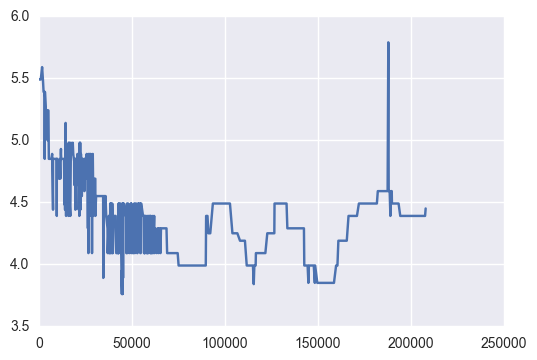

In [179]:
plt.plot(segment['rate'])